In [1]:
import numpy as np
import math
import mpmath as mp
mp.mp.dps = 100
import cmath
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# pip install mpmath

In [3]:
from VEAnalytic import *

### Inputs

In [4]:
# # [kg/m^3] density above the crust, crutal density, mantle density, core density
# densityov,densitycri,densitymi,densityci = 1030, 2800, 3330, 6600
# # [pascal] shear modulus 
# amui = 3.33333333333e10
# # [m] mantle thickness
# ddi = 3e6
# # [km] the initial height, half-width at the top, the difference in radius between the base and top of the seamount. 
# # The last parameter is the half-width of the box (this gives the longest wavelength in the calculation).  
# v_or_t,all0,ramp0,boxl = 5., 40, 20.0, 1500.0 
# v_or_t = 1000*v_or_t
# # total of harmonics, total of points
# kkt,nox = 250,301  
# # the activation energy, activation volume,the age of seafloor, not used in calculation 
# # tcon1,tcon2,age = 6.00000e+04, 5.00000e-06, 7.00000e+01
# # number of rheological layers
# nlayers = 3
# # 0: mantle; 1: crust , starting depth, ending depth, viscosity[Pa.s]
# imark = mp.matrix([0,0,1])
# depth0i = mp.matrix([3e3,1e2,1e1])
# depth1i = mp.matrix([1e2,1e1,0])
# visci = mp.matrix([1e21,1e21,1e24])
# # [year] the time for output
# ft = mp.matrix([0.,3e2,1e3,3e3,7e3, 1e4, 2e4,4e4,7e4,1e5])
# # number of time steps
# ntime = ft.rows

In [5]:
case_name = "rhoc_tem_"


# [kg/m^3] density above the crust, crutal density, mantle density, core density
densityov,densitycri,densitymi,densityci = 0, 2800, 3300, 6600
# [pascal] shear modulus 
amui = 1.5e11
# [m] mantle thickness for scaling
ddi = 6e5
# [km] the initial height, half-width at the top, the difference in radius between the base and top of the seamount. 
# The last parameter is the half-width of the box (this gives the longest wavelength in the calculation).  
v_or_t,all0,ramp0,boxl = 5., 40, 20., 600. 
v_or_t = 1000*v_or_t
# total of harmonics, total of points
kkt,nox = 250,301  
# the activation energy, activation volume,the age of seafloor, not used in calculation 
# tcon1,tcon2,age = 6.00000e+04, 5.00000e-06, 7.00000e+01
# number of rheological layers
nlayers = 3
# 0: mantle; 1: crust , starting depth, ending depth, viscosity[Pa.s]
imark = mp.matrix([0,0,1])
depth0i = mp.matrix([6e2,1e2,35])
depth1i = mp.matrix([1e2,35,0])
visci = mp.matrix([1e21,1e21,1e24])
# [year] the time for output
ft = mp.matrix([1e4,1e5,1e6])
# number of time steps
ntime = ft.rows

### Constant

In [6]:
# scaling

#delta_rho = 500
#densitym = 3300.0
#densityc = 6600.0
pi = mp.pi #DPPIC
visc0 = 1e21
amu = 1.5e11
akapa=1e-6
d=3.0e6
g=10.0
zero=0.0
year = 365.0*24*3600.0
twopig = 2.0*pi*6.6732e-11
bemillga = 1.0e05
gi = g

zsi=0.0
ami=40.0
ali=100.0

### Initial Loading

In [7]:
xcoordi = np.linspace(0,boxl*1000,nox) 
    
# mantle_s = 0
# dTempi = 0.0    
# if abs(dTempi) > 0.0:
#     mantle_s = 1
    
d = mp.mpf(ddi)
densitym=mp.mpf(densitymi)
densityc=mp.mpf(densityci)
densitycr=mp.mpf(densitycri)
delta_rho=mp.mpf(densitymi - densitycri)
delta_rhos=mp.mpf(densitycri-densityov)

iso = 0
if iso == 1:
    if dmoho != 0.0:
        dsurf = mp.mpf(-dmoho * delta_rho / delta_rhos)
    elif dsurf != 0.0:
        dmoho = mp.mpf(-dsurf * delta_rhos / delta_rho)
        
amu=amui
zs=zsi
 
zs = mp.mpf(1.0-zs*1000/d)       
depth0 = mp.matrix(nlayers,1)
depth1 = mp.matrix(nlayers,1)
for i in range(nlayers):
    depth0[i] = 1.0-depth0i[i]*1000/d
    depth1[i] = 1.0-depth1i[i]*1000/d
    if imark[i]==0: 
        am=depth1[i]
        
gama = densityc/densitym

tscaling = visc0/amu
vscaling = d/tscaling*100*year
sscaling = amu

qqq = -(1.0-gama)*densitym*g*d/amu
qqq1= -delta_rhos*g*d/amu
r0  = densitym*g*d/amu

delta_rho = delta_rho/densitym
delta_rhos = delta_rhos/densitym
v_or_t = v_or_t/d
    
visc = visci
tau  = visc/(amu*tscaling)
visc = visc/visc0

topo_s0 = mp.matrix(nox,1)
topo_s = mp.matrix(ntime, nox)
topo_m = mp.matrix(ntime, nox)
topo_b = mp.matrix(ntime, nox)

acosine = mp.matrix(nox, kkt)
ff = mp.matrix(kkt,1)
for k in range(1, kkt+1):
    wavelength1 = 2 * boxl * 1000 / k
    aki = np.float128(2 * pi / wavelength1)
    
    for ij in range(nox):
        acosine[ij, k-1] = mp.cos(xcoordi[ij] * aki)

    ak = boxl / (pi * k)
    ff[k-1] = 2 * v_or_t * ak * ak / (ramp0 * boxl) * (mp.cos(all0/ak) - mp.cos((ramp0 + all0)/ak))

    for ij in range(nox):
        topo_s0[ij] += ff[k-1] * acosine[ij, k-1] * d

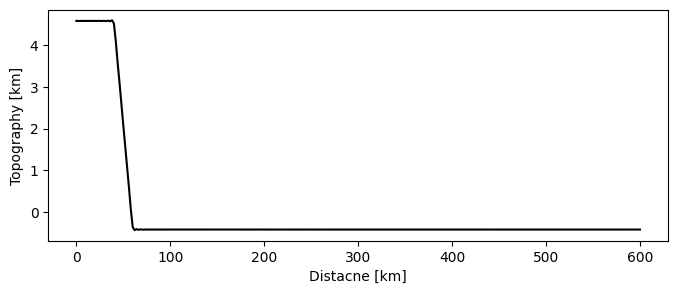

In [8]:
# Topo in nox
fig, ax1 = plt.subplots(nrows=1, figsize=(8,3))
ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]') 
#ax1.set_xlim([0,1500])
ax1.plot(xcoordi/1000,topo_s0[:]/1000,c="k",label="Vel")

In [9]:
# # harmonics
# wavelength1_ = np.zeros((kkt))
# aki_ = np.zeros((kkt))
# ki_ = np.zeros((kkt))
# for k in range(1, kkt+1):
#     wavelength1_[k-1] = 2 * boxl * 1000 / k
#     aki_[k-1] = 2 * pi / wavelength1_[k-1]
#     ki_[k-1] = k
# fig, ax1 = plt.subplots(nrows=1, figsize=(8,3))
# #ax1.set(xlabel='Distacne [km]', ylabel='Vx [cm/yr]') 
# ax1.plot(ki_,ff*d,c="k",label="Vel")

### Main

In [10]:
f = mp.matrix(4,1)
nii = int(20) # for aa(4,4,nii) amd caa(nii), nii=60 in fortran codes # or just simplied to 3?
for k in range(1, kkt + 1):
    f[0] = 0.0
    f[2] = 0.0
    f[3] = 0.0
    f[1] = ff[k - 1]

    wavelength1 = mp.mpf(2 * boxl * 1000 / k)
    wavelength = wavelength1 / d
    ak = 2 * pi / wavelength
    aki = 2 * pi / wavelength1

    atempp = f[1]
    print("k=",k, atempp)
    aa, iaa = get_unit_matrix()
    cc, icc = get_unit_matrix()


    for i in range(nlayers):
        p2, ip2 = prop1(visc[i], tau[i], ak, depth0[i], depth1[i])
        #p2_layer[:,:,:,i] = p2
        if imark[i] == 0:
            aa, iaa = matrix_multi_mat(p2, ip2, aa, iaa)
        elif imark[i] == 1:
            cc, icc = matrix_multi_mat(p2, ip2, cc, icc) 
    bb,ibb = matrix_multi_mat(cc,icc,aa,iaa)
    caa,icaa,cbb,icbb = form_alphas(nlayers,tau,ak,imark,am)
    dett,idett = form_dett(aa,iaa,bb,ibb,cc,icc,ak,r0,delta_rho,qqq,qqq1)
    co,ico = form_coeff(dett,idett)
        
    xx,dettf = eigenvalues(co,ico,dett,idett)
        
    xx1 = mp.matrix(nii,1)
    for i in range(ico-1):
        xx1[i] = xx[i]
        if xx1[i] != 0.0:
            xx1[i] = -1.0 / xx1[i] * tscaling / year
        else:
            xx1[i] = 1.0e98
    
    t_surf = eigenfunctions(xx,ico,1,dettf,caa,icaa,cbb,icbb,f,co)
    t_moho = eigenfunctions(xx,ico,2,dettf,caa,icaa,cbb,icbb,f,co)
    t_botm = eigenfunctions(xx,ico,3,dettf,caa,icaa,cbb,icbb,f,co)
    v_botm = eigenfunctions(xx,ico,4,dettf,caa,icaa,cbb,icbb,f,co)
        
    for i in range(ico-1):
        t_surfi = t_surf[i] * d
        t_mohoi = t_moho[i] * d
        t_botmi = t_botm[i] * d
        v_botmi = v_botm[i] * vscaling
       
    #dt = np.log10(dti)/(ntime-1)
    deg = mp.matrix(ntime, kkt)
    topo_sk = mp.matrix(ntime, kkt)
    topo_mk = mp.matrix(ntime, kkt)
    
    velo_b = mp.matrix(ntime, nox)
    
    for i in range(ntime):
        #t = 10**(dt * (i - 1))
        t = ft[i]
        t = t * year / tscaling

        topo_suro = 0.0
        topo_moho = 0.0
        topo_botm = 0.0
        velo_botm = 0.0

        for j in range(ico-1):
            xyz = xx[j] * t
            if xyz > -1e4:
                topo_suro += t_surf[j] * mp.exp(xx[j] * t) * d
                topo_moho += t_moho[j] * mp.exp(xx[j] * t) * d
                topo_botm += t_botm[j] * mp.exp(xx[j] * t) * d
                #velo_botm += v_botm[j] * mp.exp(xx[j]*t)*vscaling
                

        for ij in range(nox):
            topo_s[i,ij] += topo_suro * acosine[ij, k-1]
            topo_m[i,ij] += topo_moho * acosine[ij, k-1]
            topo_b[i,ij] += topo_botm * acosine[ij, k-1]
            #topo_b[i,ij] += f[2]*mp.cos(aki*xcoordi[ij])
            #velo_b[i,ij] += velo_botm * acosine[ij, k-1]
        
            if topo_suro * delta_rhos == 0:
                deg[i,k-1]  = 0.
            else:
                deg[i,k-1] = -((topo_moho * delta_rho) / (topo_suro * delta_rhos))
        topo_sk[i,k-1] = topo_suro
        topo_mk[i,k-1] = topo_moho
    
# possion=0.5
# young_m = 2.0*amui*(1.0+possion)
# consttt = 12.0*(1.0-possion*possion)/young_m
# ptt33 = 1.0/3.0
# Te = np.zeros(kkt)
# for i in range(ntime):
#     totalt = 0.0
#     totals = 0.0

#     for k in range(1,kkt+1):
#         wavelength1 = 2 * boxl * 1000 / k
#         aki = 2.0 * math.pi / wavelength1
#         ffk = ff[k-1] * d * (densitycri - densityov)
#         ddd = g * (ffk + topo_mk[i,k-1] * (densitymi - densityov))/ (topo_mk[i,k-1]*aki**4)
#         ccc = abs(consttt * ddd)
#         Te[k-1] = ccc ** ptt33

#         if k != 1:
#             totalt += Te[k-1] * abs(topo_mk[i,k-1])
#             totals += abs(topo_mk[i,k-1])
#     totalt = totalt / totals

k= 1 0.001372450370739372518900167799792840284485364164338182067854372273861544038916614980252403653827778618
k= 2 0.001323868452824159438010725994144964687562839049263494518016076780326410278474898266643008428209112392
k= 3 0.00124530344261403796175920287954774054273521702675763741616441886352921436741378447055292038140100451
k= 4 0.001140223044122731036551533425642014755561001602839439995170889024052987153167106919150832745696433456
k= 5 0.001013211836423377714438794632097276389043587746722465488456090318941731209622354411912092739256218376
k= 6 0.0008697213232129807243871290629991575493105857633588951088520089569686220670975200596770491857489616788
k= 7 0.0007157759705344569795132299387156518261084620482603467448433256438473712092957092694609174307166158898
k= 8 0.0005576532174550227835608638274974513572410762689291839234167830012136380677252285672721432830007862508
k= 9 0.0004015568167044194704307739524007929838528543854512712322742717695854499706112648987697259953184748999
k= 10 0

k= 78 -0.00001347313600539713869162991089297065930758719178452391491477265588395084728741427395528902163868730099
k= 79 -0.00001315168057918426210024897792384331670505340784295853767915759656659824330807513053278879991009486022
k= 80 -0.0000118735762080864575910796245948899576841045439069038924428448084250984126127619657645948367881588091
k= 81 -0.000009729625024954318424451964092734934227596752431408808677471168387028172844844258336948876132869850226
k= 82 -0.000006882919919648235224863339219660411118966626056748323504283570243944693420912227013468357753974303869
k= 83 -0.000003553792267904647480340028893004386990682526922724493301378188751039324579429607790744794118078281239
k= 84 1.282251312856389529236167844406012879799845023880324574410080627067662689096990431893224078811793664e-106
k= 85 0.000003505923309423452299096175197568430411915528535371852901232146432324329445060049868207933353827745248
k= 86 0.0000067000454761534616904760926282101011173819785189766446513529673926065696141

k= 151 0.000004286418240977265593904749544173105365722067544772788281871791649382695219220746929052312862698273446
k= 152 0.000003777096315275832304013126811349262031579459444862252268591635453569191309319946148309835585293022368
k= 153 0.000003022889848917503957624996879700278796306699200146301063522451562484259284459155987398100056267439816
k= 154 0.000002089455909159681340140039681153731989549549381276406807278063199347199732930697961493805642524268669
k= 155 0.000001054330735091964323037247275855646606705086104810057740328918125849876388784968170564092340537167926
k= 156 2.602439055087228452828435329179067560777200255567759343329335237184664511007501290765537627410918501e-106
k= 157 -0.0000009932279173027350599238289197901424795655778315813637207673472475925963336318133827108964533831506129
k= 158 -0.000001853899757239013525556044420485363097417545009036040988735888732586288998646603686851515684094024163
k= 159 -0.00000252506110473182560748504158903658492414312300551691759554164533

k= 226 -0.0000006636884745046078319326661826348396894151180473390859088822614458901047783387319245947256886722579195
k= 227 -0.0000003202702321959087001082056685072391009891189318223275207658614933934011997248860506035109772253583456
k= 228 4.942883454213162517687122360873705051328156053273849522850604433870801656917927659342411712117706545e-106
k= 229 0.0000002723543305256246166180689791230524895235632344181447701508702914050771947300537002332999311541261911
k= 230 0.0000004788335710885527951034001096868035865045310712298986240340691488382472635266325198072271924651315579
k= 231 0.0000006095482122347402991865349252162484153610540511151022247374676886943919270536994584124698866362412038
k= 232 0.0000006630834928121555095848559185463155258514581081203138209474233070316742779134703534746055683719218202
k= 233 0.0000006460428918600156937160063179846182371993339417701005820207216295846523099613136031900560722266790439
k= 234 0.000000571808891001302251405081566731859006778820357237932352959

In [11]:
# print(format{}."float(atempp)")

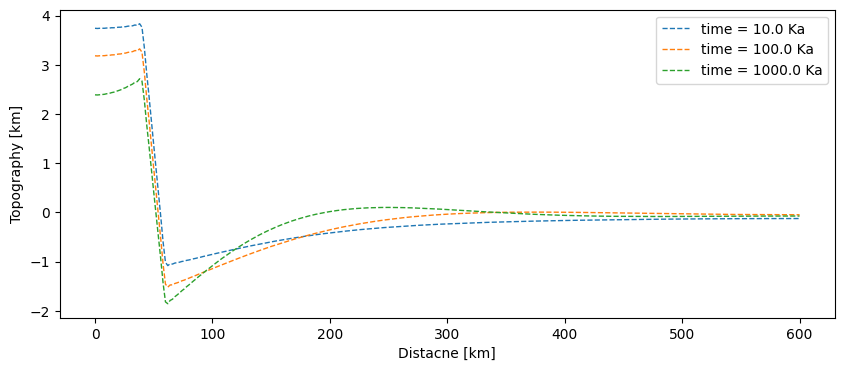

In [12]:
figsize = (10,4)

fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]') 

#ax1.plot(xcoordi/1000,topo_s[0,:]/1000, "-k", label = f"time = {ft[0]/1000.} Ka", linewidth = 1)
    
for i in range(ntime):
    ax1.plot(xcoordi/1000,topo_s[i,:]/1000, "--", label = f"time = {ft[i]/1000.} Ka", linewidth = 1)
ax1.legend(loc='upper right')

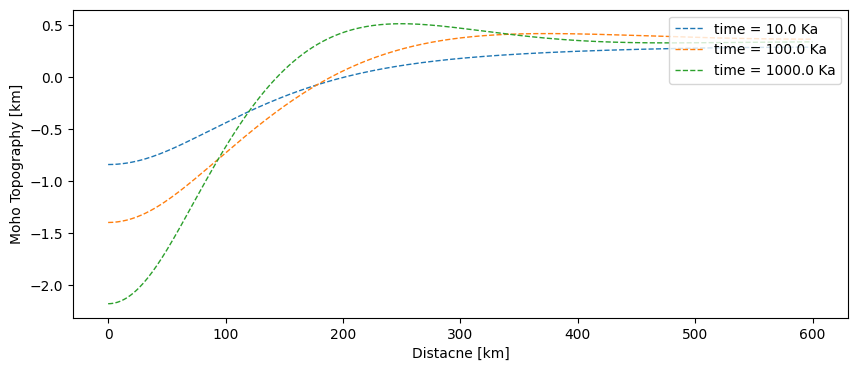

In [13]:
figsize = (10,4)

fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
ax1.set(xlabel='Distacne [km]', ylabel='Moho Topography [km]') 

#ax1.plot(xcoordi/1000,topo_s[0,:]/1000, "-k", label = f"time = {ft[0]/1000.} Ka", linewidth = 1)
    
for i in range(ntime):
    ax1.plot(xcoordi/1000,topo_m[i,:]/1000, "--", label = f"time = {ft[i]/1000.} Ka", linewidth = 1)
ax1.legend(loc='upper right')

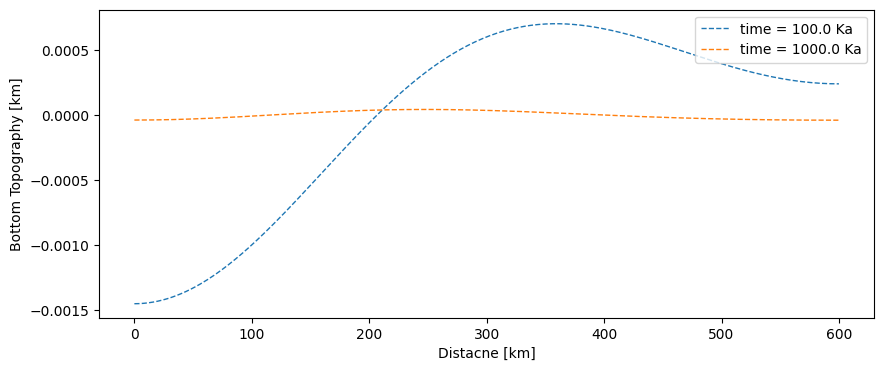

In [14]:
figsize = (10,4)

fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
ax1.set(xlabel='Distacne [km]', ylabel='Bottom Topography [km]') 

#ax1.plot(xcoordi/1000,topo_s[0,:]/1000, "-k", label = f"time = {ft[0]/1000.} Ka", linewidth = 1)
    
for i in range(1,ntime):
    ax1.plot(xcoordi/1000,topo_b[i,:]/1000, "--", label = f"time = {ft[i]/1000.} Ka", linewidth = 1)
ax1.legend(loc='upper right')

In [15]:
fname_save = case_name+'topo_s_time.txt'
data = topo_s/1000

with open(fname_save, 'w') as file:
    for i in range(nox):
        row = np.float32(data[:,i])
        formatted_row = [f'{element:12.5e}' for element in row]  
        row_text = ' '.join(formatted_row)  
        file.write(row_text + '\n')   
        
fname_save = case_name+'topo_m_time.txt'
data = topo_m/1000
with open(fname_save, 'w') as file:
    for i in range(nox):
        row = np.float32(data [:,i])
        formatted_row = [f'{element:12.5e}' for element in row]  
        row_text = ' '.join(formatted_row)  
        file.write(row_text + '\n') 
        
fname_save = case_name+'topo_b_time.txt'
data = topo_b/1000
with open(fname_save, 'w') as file:
    for i in range(nox):
        row = np.float32(data [:,i])
        formatted_row = [f'{element:12.5e}' for element in row]  
        row_text = ' '.join(formatted_row)  
        file.write(row_text + '\n')   
        
fname_save = case_name+'topo_x.txt'
data = xcoordi/1000
with open(fname_save, 'w') as file:
    row = np.float32(data)
    formatted_row = [f'{element:12.5e}' for element in row]  
    row_text = ' '.join(formatted_row)  
    file.write(row_text + '\n')   

In [16]:
# figsize = (10,4)

# fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
# ax1.set(xlabel='Distacne [km]', ylabel='Moho Topography [km]') 

# for i in range(ntime):
#     ax1.plot(xcoordi/1000,data_plot_[:,i]/1000, "--", label = f"time = {ft[i]/1000.} Ka", linewidth = 1)
# ax1.legend(loc='upper right')

In [17]:
# figsize = (10,4)

# fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
# ax1.set(xlabel='Distacne [km]', ylabel='Moho Topography [km]') 

# ax1.plot(xcoordi/1000,data_plot_[:,0]/1000, "--", label = f"time = {ft[i]/1000.} Ka", linewidth = 1)
# ax1.legend(loc='upper right')

In [18]:
# figsize = (10,4)

# fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
# ax1.set(xlabel='Distacne [km]', ylabel='Velocisty [cm/year]') 

# #ax1.plot(xcoordi/1000,topo_s[0,:]/1000, "-k", label = f"time = {ft[0]/1000.} Ka", linewidth = 1)
    
# for i in range(ntime):
#     ax1.plot(xcoordi/1000,velo_b[i,:], "--", label = f"time = {ft[i]/1000.} Ka", linewidth = 1)
# ax1.legend(loc='upper right')

In [19]:
# figsize = (10,4)

# fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
# ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]') 

# ax1.plot(xcoordi/1000,topo_s[0,:]/1000, "-k", label = f"time = {ft[0]/1000.} Ka", linewidth = 1)


In [20]:
# figsize = (10,4)

# fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
# ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]') 

# for i in range(ntime):
#     ax1.plot(xcoordi/1000,topo_m[i,:]/1000, "--", label = f"time = {ft[i]/1000.} Ka", linewidth = 1)
# ax1.legend(loc='upper right')

### Outputs from source codes

In [21]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

In [22]:
# fname = "out_time.case1"

# f=open(fname,"r")
# lines=f.readlines()

# # number of time steps to work on
# cntr = 0
# len_arr = []
# for l in lines:
#     lstrip = l.split(sep = "\t")
#     lstrip = lstrip[1:-1]
#     if len(lstrip) == 2:
#         cntr += 1 
#     len_arr.append(len(lstrip))

# len_arr = np.array(len_arr)
# print(np.unique(len_arr))

In [23]:
# # split into the appropriate groups
# time_dict = {}
# topo_dict = {}
# wave_dict = {}

# time_idx = 0
# data_idx = 0

# topo_dummy = []
# wave_dummy = []

# for l in lines:
#     lstrip = l.split(sep = "\t")
#     lstrip = lstrip[1:-1]
#     #print(lstrip)
#     if len(lstrip) == 2:
#         res = [eval(i) for i in lstrip]
#         time_dict[time_idx] = res

#         if time_idx > 0: # save the data from previous time step
#             topo_df = pd.DataFrame(topo_dummy, columns = ["C1", "C2", "C3"])
#             topo_dict[data_idx] = topo_df

#             wave_df = pd.DataFrame(wave_dummy, columns = ["C1", "C2", "C3", "C4", "C5"])
#             wave_dict[data_idx] = wave_df

#             topo_dummy = []
#             wave_dummy = []
#             data_idx += 1
        
#         time_idx += 1
    
#     elif len(lstrip) == 3:
#         res = [eval(i) for i in lstrip]
#         topo_dummy.append(res)

#     elif len(lstrip) == 5:
#         res = [eval(i) for i in lstrip]
#         wave_dummy.append(res)

# # save the last one
# topo_df = pd.DataFrame(topo_dummy, columns = ["C1", "C2", "C3"])
# topo_dict[data_idx] = topo_df

# wave_df = pd.DataFrame(wave_dummy, columns = ["C1", "C2", "C3", "C4", "C5"])
# wave_dict[data_idx] = wave_df

In [24]:
# figsize = (10,4)
# ## 
# fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
# ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]',title="Error") 
# for i in range(len(topo_dict.keys())):
#     topo_plot = topo_dict[i]
#     time_plot = time_dict[i]

#     ax1.plot(topo_plot["C1"], topo_plot["C2"]/1000.-topo_s[i,:]/1000.)
# ax1.legend(loc='upper right')

In [25]:
# figsize = (10,4)
# ## 
# fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
# ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]',title="Error") 
# for i in range(len(topo_dict.keys())):
#     topo_plot = topo_dict[i]
#     time_plot = time_dict[i]

#     ax1.plot(topo_plot["C1"], topo_plot["C3"]/1000.-topo_m[i,:]/1000.)
# ax1.legend(loc='upper right')